In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Loading...
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
from fastai.callbacks import *
import cv2
import matplotlib


In [3]:
## Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/densenet201/densenet201-4c113574.pth' '/tmp/.cache/torch/checkpoints/densenet201-c1103571.pth'

cp: cannot stat '../input/densenet201/densenet201-4c113574.pth': No such file or directory


In [4]:
root = '/kaggle/input/aptos2019-blindness-detection/'
train_df = pd.read_csv(os.path.join(root, 'train.csv'))

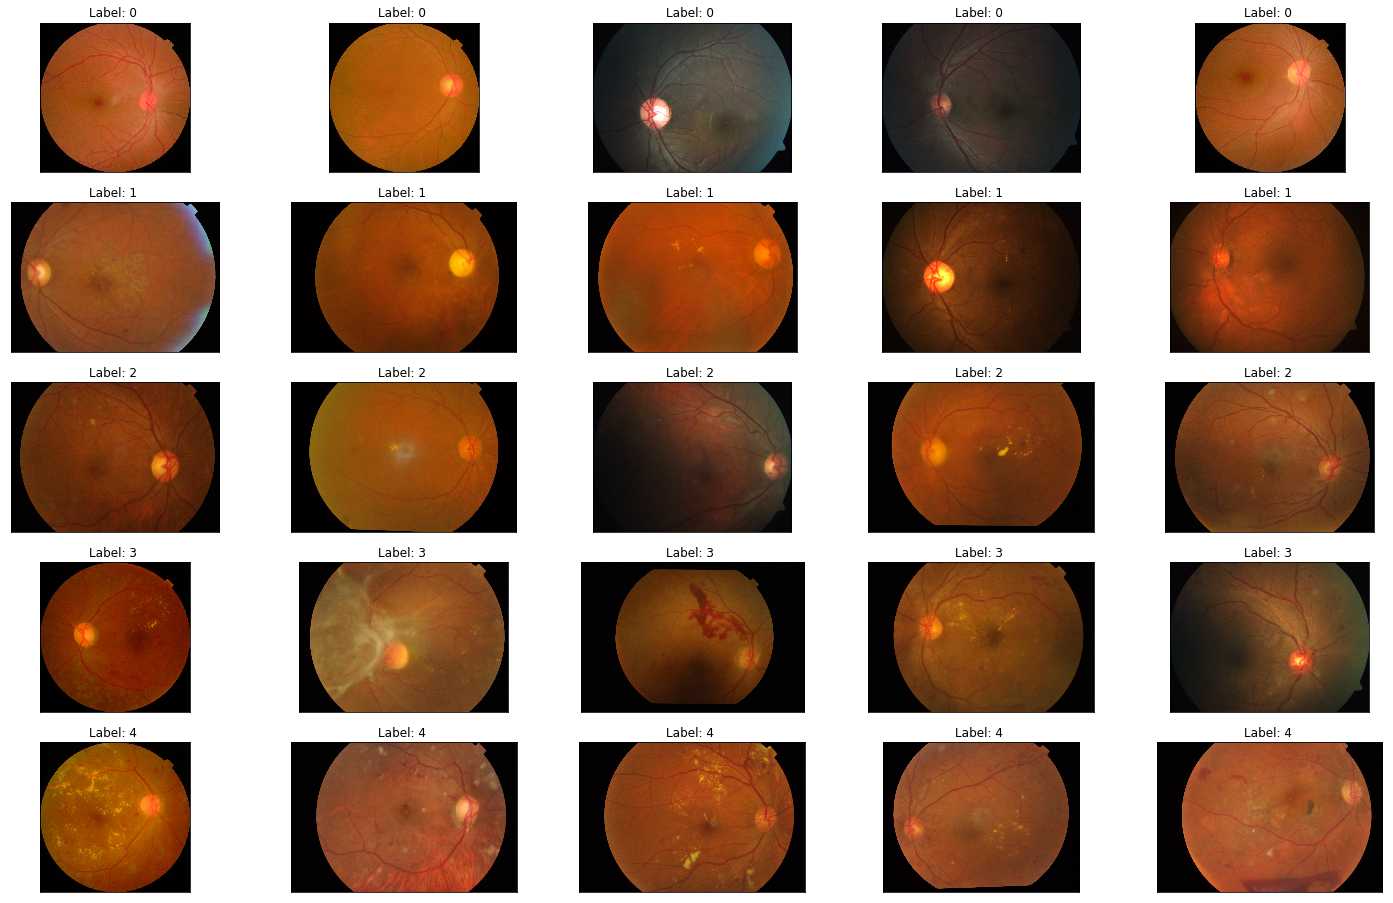

In [5]:

SEED = 125
fig = plt.figure(figsize=(25, 16))
img_list = []
img_size = []
# display 10 images from each class
#for class_id in sorted(train_y.unique()):
for class_id in [0, 1, 2, 3, 4]:
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = os.path.join(root, 'train_images', '{}.png'.format(row['id_code']))
        image = cv2.imread(path)
        img_size.append(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        img_list.append(row['id_code'])
        
        plt.imshow(image)
        ax.set_title('Label: %d ' % (class_id) )

#  Median subtraction

In [6]:
IMAGE_SIZE = 256

def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]
    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

def resize_image(im, augmentation=False):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE)) # This is the most important line

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)


In [7]:
PARAM = 96
def Radius_Reduction(img,PARAM):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(math.floor(w/2)),int(math.floor(h/2))),int(math.floor((h*PARAM)/float(2*100))), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

# Read image

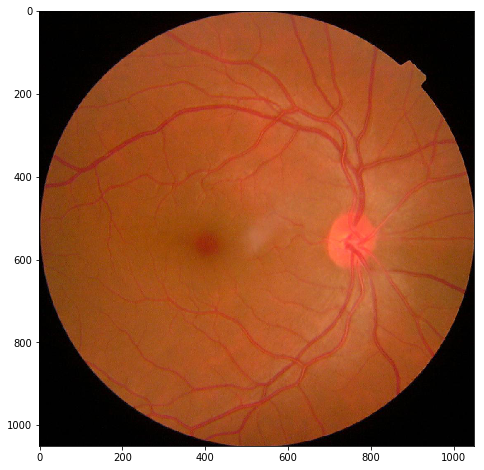

In [8]:
image = cv2.imread(os.path.join(root, 'train_images', '{}.png'.format(img_list[0])))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(8, 8))
plt.imshow(image)

# Resizing the image

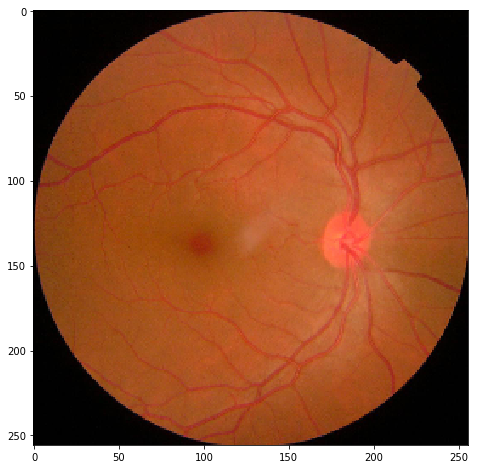

In [9]:
fig=plt.figure(figsize=(8, 8))
res_image = resize_image(image)
plt.imshow(res_image)

# Subtracting the median blur image from the original

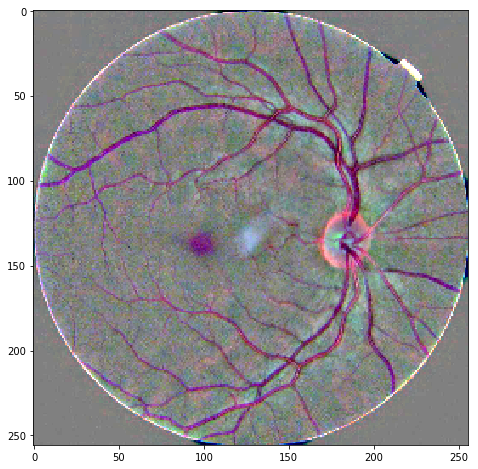

In [10]:
fig=plt.figure(figsize=(8, 8))
sub_med = subtract_median_bg_image(res_image)
plt.imshow(sub_med)

# Removing the circular boundary to remove irregularities

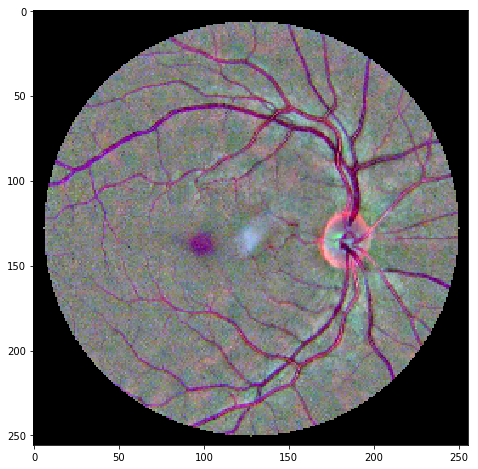

In [11]:
fig=plt.figure(figsize=(8, 8))
img_rad_red=Radius_Reduction(sub_med, PARAM)
plt.imshow(img_rad_red)

# The above collection of pre-processing was done for 5 images belonging to each of the five classes.

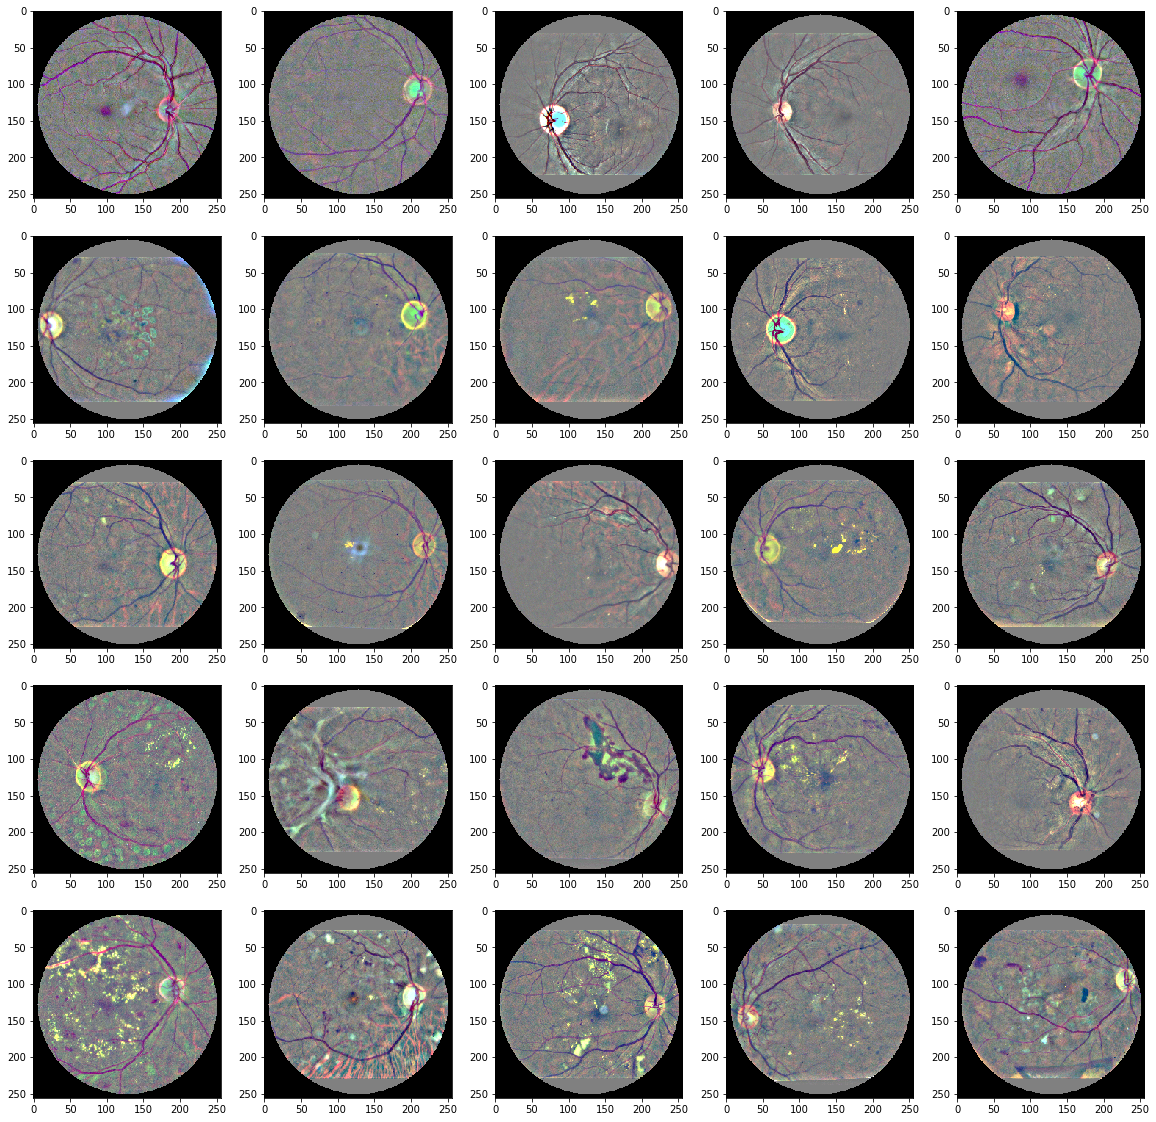

In [12]:
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    img = cv2.imread(os.path.join(root, 'train_images', '{}.png'.format(img_list[i-1])))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res_image = resize_image(img)
    sub_med = subtract_median_bg_image(res_image)
    img_rad_red=Radius_Reduction(sub_med, PARAM)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_rad_red)
plt.show()

 # Gamma Correction
 
 ### The Gamma value builds a relation between the pixel value and its actual brightness in an image.

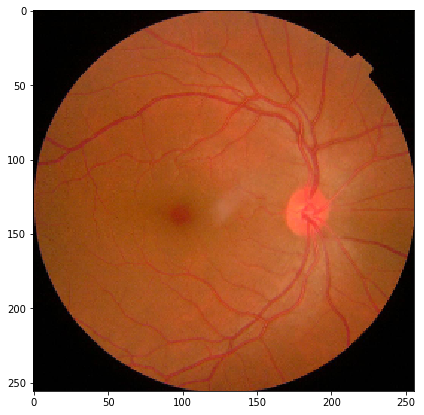

In [13]:
image = cv2.imread(os.path.join(root, 'train_images', '{}.png'.format(img_list[0])))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
res_image = resize_image(image)

matplotlib.rc('figure', figsize=[7, 7])
plt.imshow(res_image)

In [14]:
def adjust_gamma(image, gamma):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                for i in np.arange(0, 256)]).astype("uint8")
    
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

A value **< 1.0** will make the image **darker** while values **> 1.0** makes the image **brighter**

In [15]:
adjusted = adjust_gamma(res_image, gamma=0.5)
adjusted_75 = adjust_gamma(res_image, gamma=0.75)
adjusted_15 = adjust_gamma(res_image, gamma=1.5)
adjusted_3 = adjust_gamma(res_image, gamma=2.5)

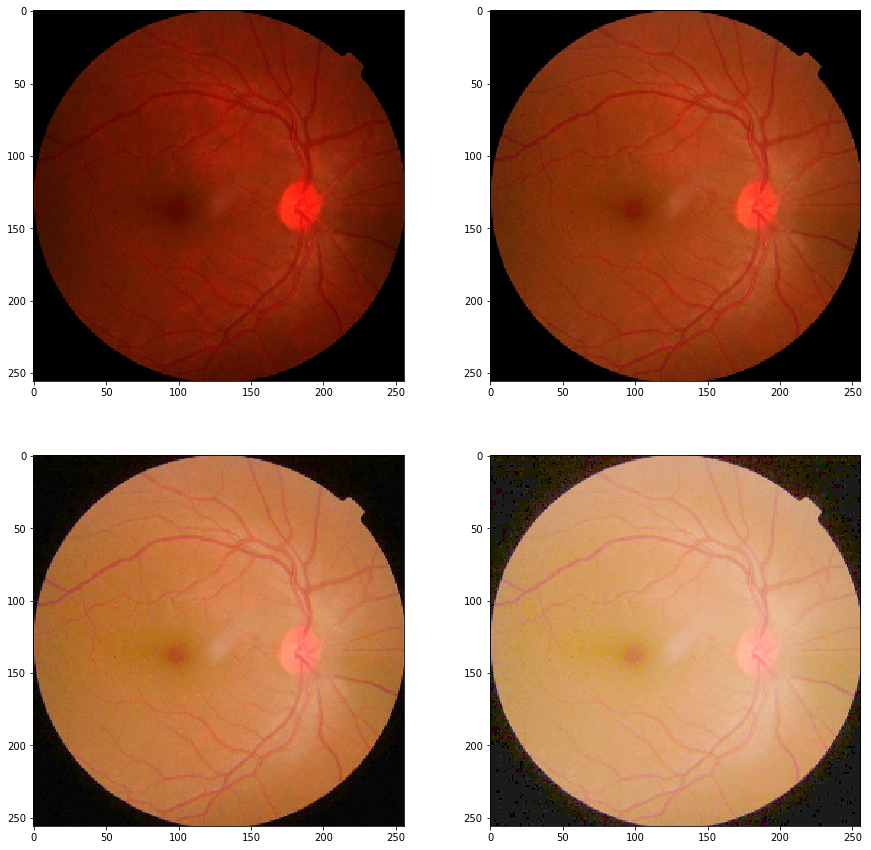

In [16]:
matplotlib.rc('figure', figsize=[15, 15])

fig, axarr = plt.subplots(2,2)
axarr[0,0].imshow(adjusted)
axarr[0,1].imshow(adjusted_75)
axarr[1,0].imshow(adjusted_15)
axarr[1,1].imshow(adjusted_3)

# Training the model using DenseNet 201

In [17]:
os.listdir('../input')

['aptos2019-blindness-detection']

In [18]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


In [19]:
# Set seed fol all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [20]:
# Reading train_dataset
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

diagnosis                                               path
0          2  ../input/aptos2019-blindness-detection/train_i...
1          2  ../input/aptos2019-blindness-detection/train_i...
2          2  ../input/aptos2019-blindness-detection/train_i...
3          1  ../input/aptos2019-blindness-detection/train_i...
4          0  ../input/aptos2019-blindness-detection/train_i...

In [21]:
# Set Batch Size and Image size
bs = 32 
sz=224

In [22]:
# Data Augmentation and Transformation up to Data Bunch
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_warp=0.,
                      max_zoom=1.05,
                      max_lighting=0.1,
                      p_lighting=0.5
                     )
src = (ImageList.from_df(df=df
                         ,path='./'
                         ,cols='path'
                         #,convert_mode='L'
                        ) 
        .split_by_rand_pct(0.15) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)      
       )

In [23]:
# Definition of Quadratic Kappa
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

In [24]:
# Densenet201 Model definition
# Set Callback for Early Stopping
learn = cnn_learner(data, base_arch=models.densenet201, metrics = [quadratic_kappa],
                    callback_fns=[partial(EarlyStoppingCallback, monitor='quadratic_kappa', min_delta=0.01, patience=3)]
                    )

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /tmp/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 44.2MB/s]


In [25]:
# Fit to Data
learn.fit_one_cycle(5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 9.12E-06


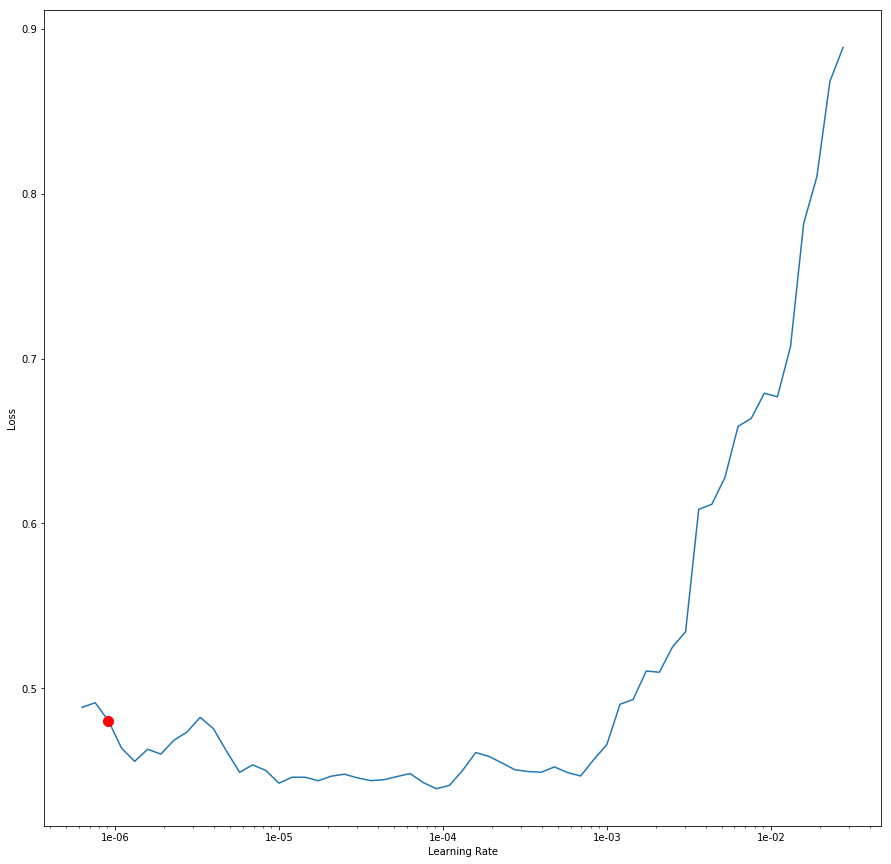

In [26]:
# Unfreeze and finding best LR
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
# First
learn.fit_one_cycle(20, max_lr=slice(5e-6,5e-5))

Epoch 8: early stopping


In [28]:
# Second for fitting again!!!
learn.fit_one_cycle(20, max_lr=slice(5e-5,5e-4))

Epoch 11: early stopping


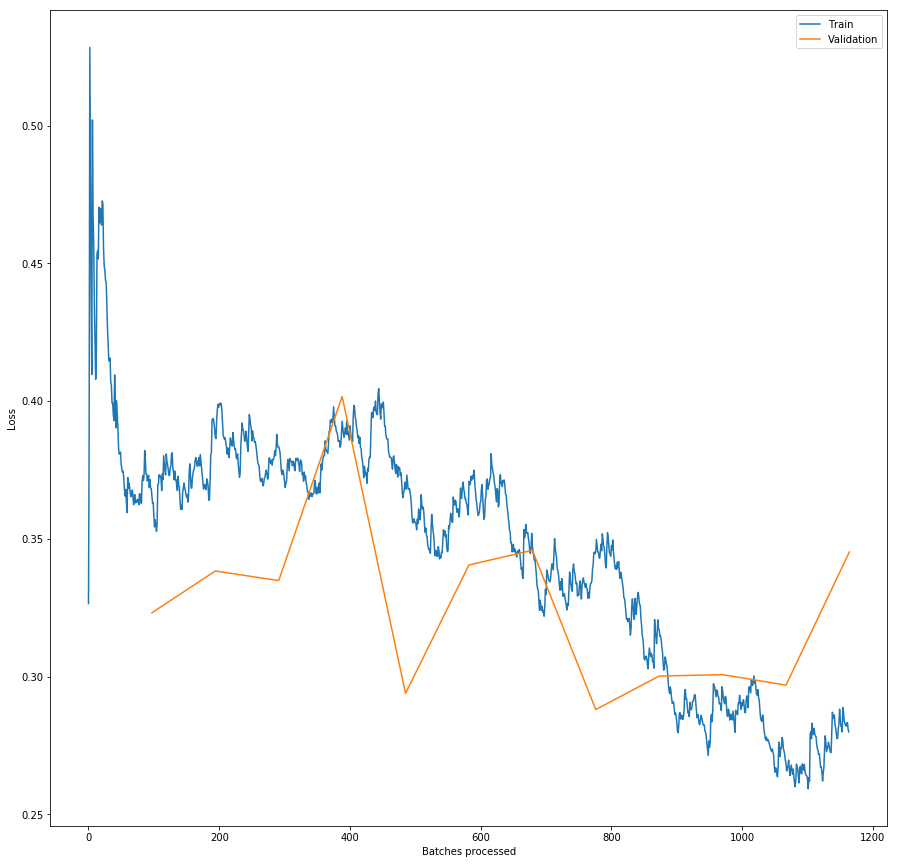

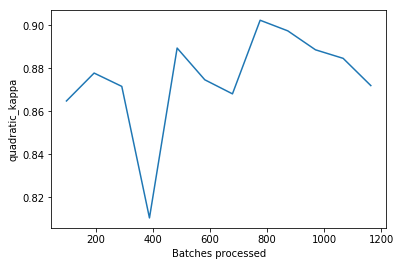

In [29]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [30]:
# Save the model
learn.export()
learn.save('stage-1')

In [31]:
# Again using data with default transformation and different Image Size
bs = 32 
sz=320
tfms = get_transforms()
src = (ImageList.from_df(df=df
                         ,path='./'
                         ,cols='path'
                        ) 
        .split_by_rand_pct(0.20) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)      
       )

In [32]:
# loading the weights and replacing the data
learn.load('stage-1') 
learn.data = data 


In [33]:
# Clear cache for GPU
torch.cuda.empty_cache()

In [34]:
learn.freeze()
learn.fit_one_cycle(4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


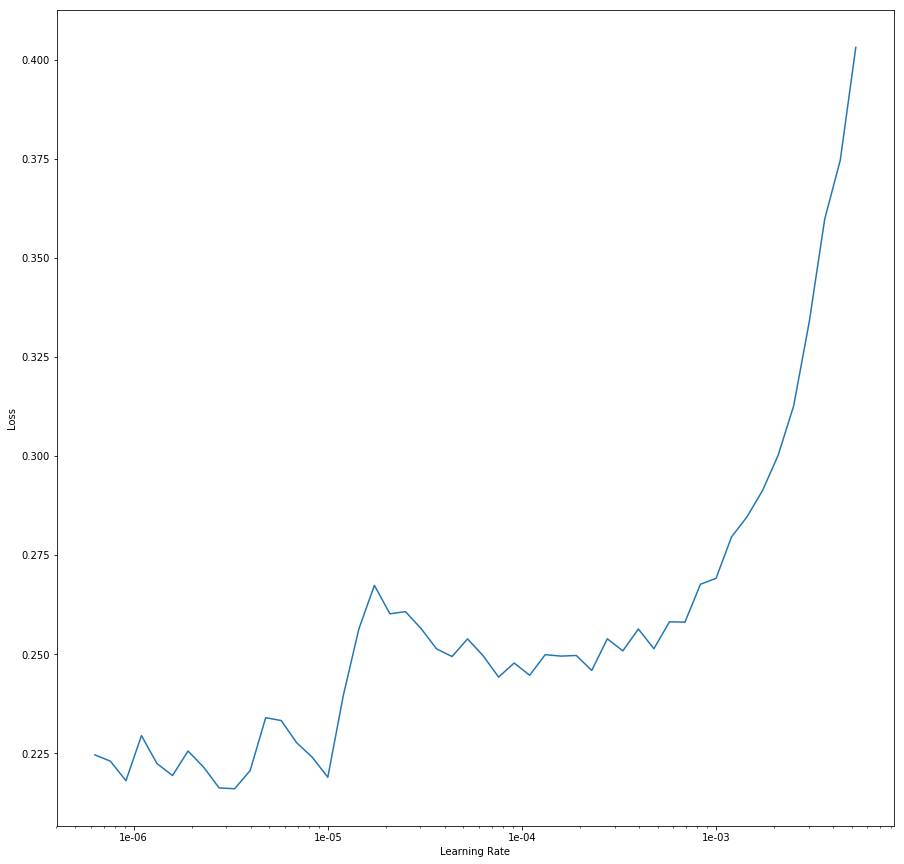

In [35]:
# Finding best LR
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [36]:
# Fit the model
learn.fit_one_cycle(20, max_lr=slice(1e-6, 8e-5))
learn.save('stage-2')

Epoch 4: early stopping


In [37]:
# Classification Interpretation
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()


In [38]:
# Predict the valid data set
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)


In [39]:
# Optimizer Class for Classification
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [40]:
# Fiting the optimizer
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])

0.9516370155778798


In [41]:
coefficients = optR.coefficients()

In [42]:
print(coefficients)

[0.515337 1.457259 2.447888 3.207203]


In [43]:
# Reading Sample Submission
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0

In [44]:
# Reading test data
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [45]:
# Using Fst AI TTA
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [46]:
# Predict the Classes
test_predictions = optR.predict(preds, coefficients)

In [47]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.groupby('diagnosis').count()

id_code
diagnosis         
0              181
1              378
2             1016
3              302
4               51

In [48]:
sample_df.to_csv('submission.csv',index=False)